In [36]:
import os
import pandas as pd
from glob import glob
from sklearn.metrics import r2_score
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene
import scikit_posthocs as sp
import matplotlib.gridspec as gridspec

In [23]:
def find_all_prediction_files(root_dir):
    return glob(os.path.join(root_dir, "*", "*", "*_preds.csv"))

def parse_model_dataset_from_path(path):
    parts = path.replace("\\", "/").split("/")
    model = os.path.basename(os.path.dirname(os.path.dirname(path))).replace("_preds", "")
    dataset = os.path.basename(os.path.dirname(path))
    return model, dataset

def load_all_predictions(root_dir):
    all_files = find_all_prediction_files(root_dir)
    records = []

    for fpath in all_files:
        df = pd.read_csv(fpath)

        if not {'rep', 'fold', 'label', 'pred'}.issubset(df.columns):
            print(f"[⚠️] Skipping: {fpath} (missing required columns)")
            continue

        model, dataset = parse_model_dataset_from_path(fpath)
        rep = str(df['rep'].iloc[0])
        fold = str(df['fold'].iloc[0])
        fold_id = f"{rep}_{fold}"
        mae = (df["label"] - df["pred"]).abs().mean()
        r2 = r2_score(df["label"], df["pred"])

        records.append({
            "model": model,
            "dataset": dataset,
            "combo": f"{model}_{dataset}",
            "fold_id": fold_id,
            "MAE": mae,
            "R2": r2
        })

    df_all = pd.DataFrame(records)
    print("\n[✅] Loaded fold-level metrics:")
    print(df_all.groupby("combo").size())  # Expect ~25 per combo
    return df_all


In [69]:
# === Assumptions Check ===

def check_anova_assumptions(df, metric, group_col):
    print(f"\n[🔎] Assumptions check for {metric} by {group_col}")
    model = ols(f"{metric} ~ C({group_col})", data=df).fit()
    residuals = model.resid
    _, p_shapiro = shapiro(residuals)
    _, p_levene = levene(*[g[metric].values for _, g in df.groupby(group_col)])
    print(f"Shapiro-Wilk p = {p_shapiro:.4f} {'✅' if p_shapiro > 0.05 else '❌'}")
    print(f"Levene's test p = {p_levene:.4f} {'✅' if p_levene > 0.05 else '❌'}")
    return p_shapiro > 0.05 and p_levene > 0.05

# === MCSim Plot for Subplots ===

import seaborn as sns
import pandas as pd
import numpy as np

def plot_mcsim_matrix_subplot(results_df, metric, dataset, ax, vmin=-0.025, vmax=0.025, cbar_ax=None):
    groups = sorted(set(results_df["group1"]).union(results_df["group2"]))
    pivot = pd.DataFrame(np.nan, index=groups, columns=groups)
    annot = pd.DataFrame("", index=groups, columns=groups)

    # Normalize metric name
    metric = metric.lower()
    higher_is_better = metric in [
        "r2", "r", "pearson", "rocauc", "prauc", "recall", "precision", "accuracy", "rho"
    ]

    for _, row in results_df.iterrows():
        g1, g2 = row["group1"], row["group2"]
        meandiff = row["meandiff"]

        # Flip direction for coloring
        diff_for_color = -meandiff if higher_is_better else meandiff
        annot_diff = -meandiff

        # Significance stars
        p = row["p-adj"]
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = ""

        # Symmetric fill
        pivot.loc[g1, g2] = diff_for_color
        pivot.loc[g2, g1] = -diff_for_color
        annot.loc[g1, g2] = f"{annot_diff:+.3f}\n{star}"
        annot.loc[g2, g1] = f"{-annot_diff:+.3f}\n{star}"

    # Ensure diagonals are filled
    for g in groups:
        pivot.loc[g, g] = 0.0
        annot.loc[g, g] = "0.0"

    # Plot with no mask
    sns.heatmap(
        pivot.astype(float), annot=annot, fmt="", cmap="coolwarm", center=0,
        vmin=vmin, vmax=vmax, ax=ax, cbar=(cbar_ax is not None),
        cbar_ax=cbar_ax, annot_kws={"fontsize": 10},
        mask=np.zeros_like(pivot, dtype=bool)  # <- explicitly disable masking
    )

    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)




def plot_conover_matrix_subplot(pval_df, dataset, metric, ax):
    sorted_groups = sorted(pval_df.index)
    pval_df = pval_df.loc[sorted_groups, sorted_groups]
    annotated = pval_df.copy()

    for i in annotated.index:
        for j in annotated.columns:
            if i == j:
                annotated.loc[i, j] = "0.0"  # Diagonal clarity
                pval_df.loc[i, j] = 0.0
                continue

            p = annotated.loc[i, j]
            if pd.isna(p):
                continue
            if p < 0.001:
                annotated.loc[i, j] = "***"
            elif p < 0.01:
                annotated.loc[i, j] = "**"
            elif p < 0.05:
                annotated.loc[i, j] = "*"
            else:
                annotated.loc[i, j] = ""

    sns.heatmap(pval_df.astype(float), annot=annotated, fmt="", cmap="Reds", vmin=0, vmax=1,
                ax=ax, cbar=(ax==0), cbar_kws={'label': 'p-value'})
    ax.set_title(f"{dataset}")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# === Run MCSim Plots in Row per Metric ===

def compare_models_within_each_dataset(df_all):
    for metric in ["MAE", "R2"]:
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f"[Model Comparison] {metric}", fontsize=14)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])
        axs = [fig.add_subplot(gs[i]) for i in range(3)]
        cbar_ax = fig.add_subplot(gs[3])

        for i, dataset in enumerate(sorted(df_all['dataset'].unique())):
            subset = df_all[df_all['dataset'] == dataset]
            valid = check_anova_assumptions(subset, metric, group_col="model")

            if valid:
                print(f"\n[✅] ANOVA + Tukey HSD for {dataset} - {metric}")
                model = ols(f"{metric} ~ C(model)", data=subset).fit()
                print(anova_lm(model, typ=2))
                tukey = pairwise_tukeyhsd(subset[metric], subset["model"])
                results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
                plot_mcsim_matrix_subplot(results, metric, dataset, axs[i], cbar_ax=cbar_ax if i == 0 else None)
            else:
                print(f"\n[⚠️] Conover + Holm for {dataset} - {metric}")
                pvals = sp.posthoc_conover(subset, val_col=metric, group_col="model", p_adjust='holm')
                plot_conover_matrix_subplot(pvals, dataset, metric, axs[i])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [70]:
# load results
root_dir = "/home/malves/predinhib_mtb/results"
df_all = load_all_predictions(root_dir)


[✅] Loaded fold-level metrics:
combo
dnn_h37rv    25
dnn_nr       25
dnn_raw      25
rf_h37rv     25
rf_nr        25
rf_raw       25
svr_h37rv    25
svr_nr       25
svr_raw      25
dtype: int64


In [71]:
df_all

,model,dataset,combo,fold_id,MAE,R2
0,rf,raw,rf_raw,0_0,0.413897,0.634165
1,rf,raw,rf_raw,0_1,0.425852,0.621371
2,rf,raw,rf_raw,0_2,0.426474,0.602363
3,rf,raw,rf_raw,0_3,0.422119,0.620917
4,rf,raw,rf_raw,0_4,0.426130,0.619563
...,...,...,...,...,...,...
220,dnn,nr,dnn_nr,4_0,0.408197,0.652965
221,dnn,nr,dnn_nr,4_1,0.410883,0.638758
222,dnn,nr,dnn_nr,4_2,0.416375,0.632952
223,dnn,nr,dnn_nr,4_3,0.409444,0.643041



[🔎] Assumptions check for MAE by model
Shapiro-Wilk p = 0.0998 ✅
Levene's test p = 0.2907 ✅

[✅] ANOVA + Tukey HSD for h37rv - MAE
            sum_sq    df          F    PR(>F)
C(model)  0.001322   2.0  16.049705  0.000002
Residual  0.002966  72.0        NaN       NaN

[🔎] Assumptions check for MAE by model
Shapiro-Wilk p = 0.4027 ✅
Levene's test p = 0.5228 ✅

[✅] ANOVA + Tukey HSD for nr - MAE
            sum_sq    df          F        PR(>F)
C(model)  0.001788   2.0  25.888588  3.379943e-09
Residual  0.002486  72.0        NaN           NaN

[🔎] Assumptions check for MAE by model
Shapiro-Wilk p = 0.4517 ✅
Levene's test p = 0.1785 ✅

[✅] ANOVA + Tukey HSD for raw - MAE
            sum_sq    df          F        PR(>F)
C(model)  0.001062   2.0  21.306932  5.388058e-08
Residual  0.001795  72.0        NaN           NaN


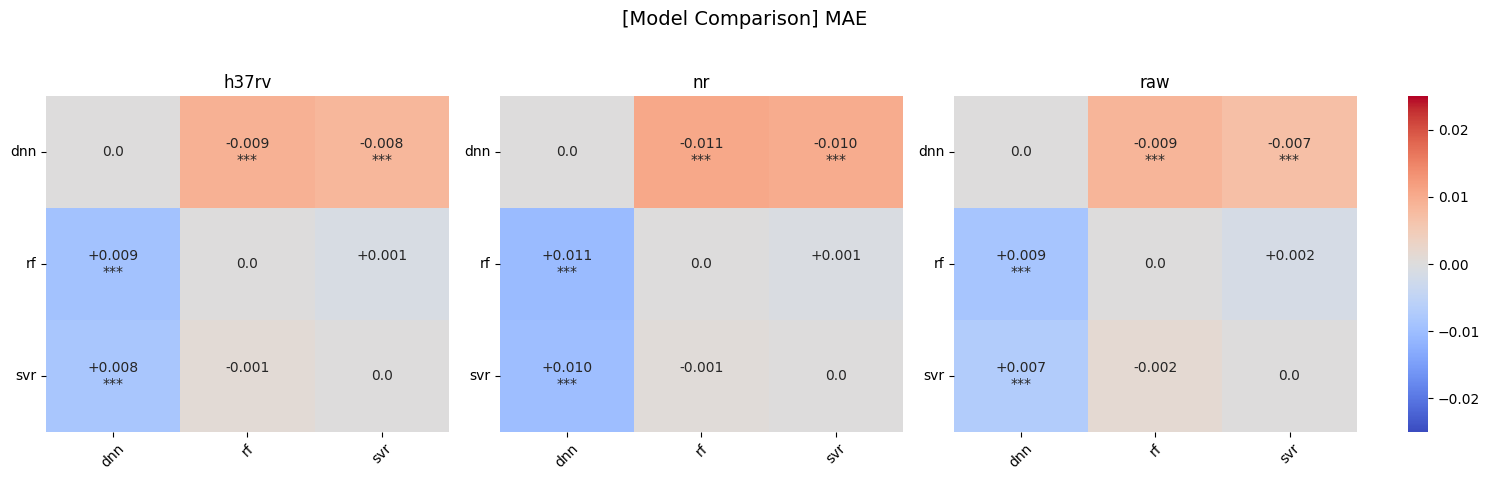


[🔎] Assumptions check for R2 by model
Shapiro-Wilk p = 0.3163 ✅
Levene's test p = 0.5752 ✅

[✅] ANOVA + Tukey HSD for h37rv - R2
            sum_sq    df          F    PR(>F)
C(model)  0.003473   2.0  11.946559  0.000033
Residual  0.010467  72.0        NaN       NaN

[🔎] Assumptions check for R2 by model
Shapiro-Wilk p = 0.4051 ✅
Levene's test p = 0.5634 ✅

[✅] ANOVA + Tukey HSD for nr - R2
            sum_sq    df          F        PR(>F)
C(model)  0.006634   2.0  27.885795  1.077296e-09
Residual  0.008565  72.0        NaN           NaN

[🔎] Assumptions check for R2 by model
Shapiro-Wilk p = 0.0867 ✅
Levene's test p = 0.5820 ✅

[✅] ANOVA + Tukey HSD for raw - R2
            sum_sq    df          F        PR(>F)
C(model)  0.004451   2.0  19.774295  1.429759e-07
Residual  0.008103  72.0        NaN           NaN


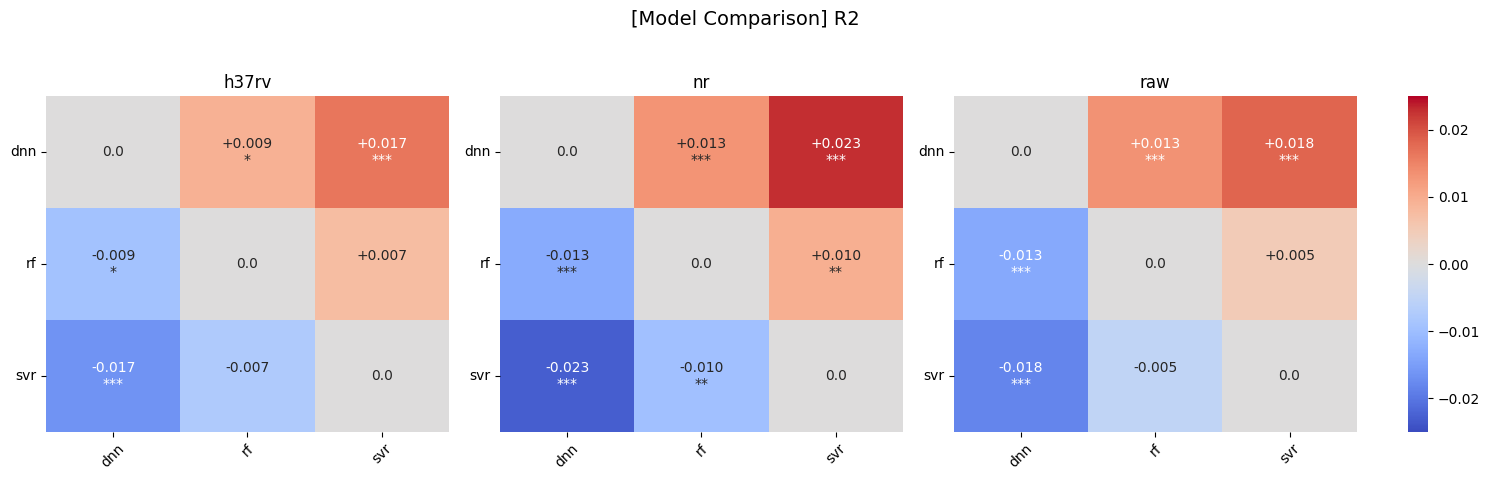

In [72]:
compare_models_within_each_dataset(df_all)

In [73]:
def compare_datasets_within_each_model(df_all):
    for metric in ["MAE", "R2"]:
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f"[Dataset Comparison] {metric}", fontsize=14)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])
        axs = [fig.add_subplot(gs[i]) for i in range(3)]
        cbar_ax = fig.add_subplot(gs[3])

        for i, model in enumerate(sorted(df_all['model'].unique())):
            subset = df_all[df_all['model'] == model]
            valid = check_anova_assumptions(subset, metric, group_col="dataset")

            if valid:
                print(f"\n[✅] ANOVA + Tukey HSD for {model} - {metric}")
                model_fit = ols(f"{metric} ~ C(dataset)", data=subset).fit()
                print(anova_lm(model_fit, typ=2))
                tukey = pairwise_tukeyhsd(subset[metric], subset["dataset"])
                results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
                plot_mcsim_matrix_subplot(results, metric, model, axs[i], cbar_ax=cbar_ax if i == 0 else None)
            else:
                print(f"\n[⚠️] Conover + Holm for {model} - {metric}")
                pvals = sp.posthoc_conover(subset, val_col=metric, group_col="dataset", p_adjust='holm')
                plot_conover_matrix_subplot(pvals, model, metric, axs[i])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



[🔎] Assumptions check for MAE by dataset
Shapiro-Wilk p = 0.1786 ✅
Levene's test p = 0.5999 ✅

[✅] ANOVA + Tukey HSD for dnn - MAE
              sum_sq    df         F    PR(>F)
C(dataset)  0.000376   2.0  4.074607  0.021067
Residual    0.003320  72.0       NaN       NaN

[🔎] Assumptions check for MAE by dataset
Shapiro-Wilk p = 0.8121 ✅
Levene's test p = 0.4378 ✅

[✅] ANOVA + Tukey HSD for rf - MAE
              sum_sq    df         F    PR(>F)
C(dataset)  0.000431   2.0  7.966142  0.000749
Residual    0.001949  72.0       NaN       NaN

[🔎] Assumptions check for MAE by dataset
Shapiro-Wilk p = 0.1125 ✅
Levene's test p = 0.6711 ✅

[✅] ANOVA + Tukey HSD for svr - MAE
              sum_sq    df         F    PR(>F)
C(dataset)  0.000449   2.0  8.168904  0.000635
Residual    0.001978  72.0       NaN       NaN


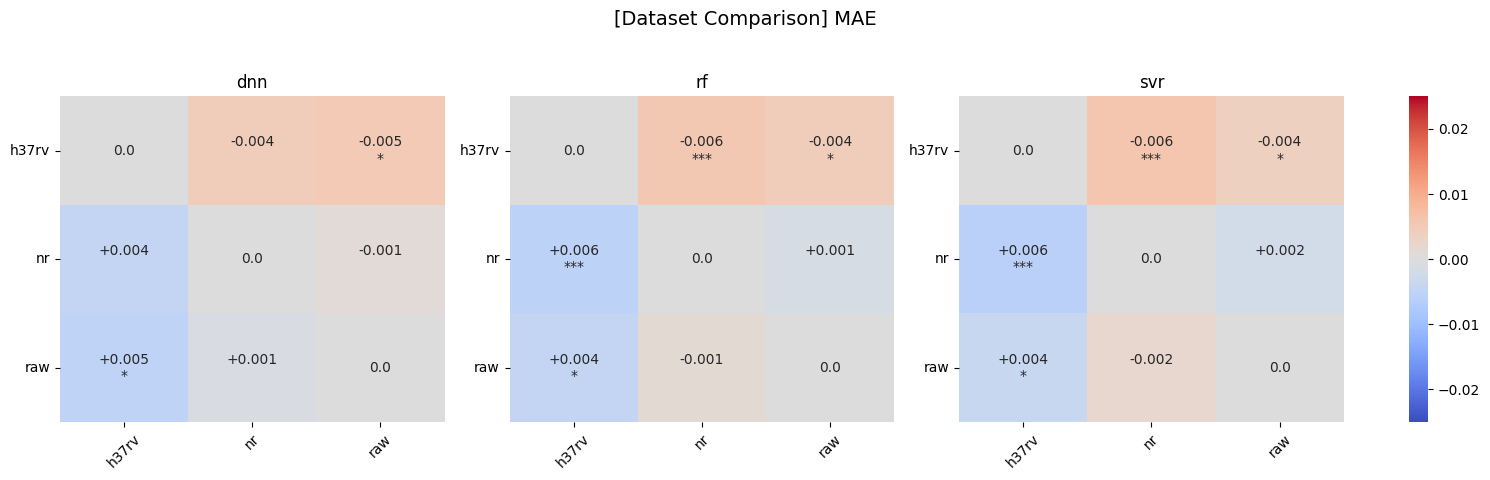


[🔎] Assumptions check for R2 by dataset
Shapiro-Wilk p = 0.3812 ✅
Levene's test p = 0.3146 ✅

[✅] ANOVA + Tukey HSD for dnn - R2
              sum_sq    df          F   PR(>F)
C(dataset)  0.003965   2.0  13.577742  0.00001
Residual    0.010512  72.0        NaN      NaN

[🔎] Assumptions check for R2 by dataset
Shapiro-Wilk p = 0.5148 ✅
Levene's test p = 0.7134 ✅

[✅] ANOVA + Tukey HSD for rf - R2
              sum_sq    df          F        PR(>F)
C(dataset)  0.006225   2.0  24.462241  7.824513e-09
Residual    0.009161  72.0        NaN           NaN

[🔎] Assumptions check for R2 by dataset
Shapiro-Wilk p = 0.6563 ✅
Levene's test p = 0.7991 ✅

[✅] ANOVA + Tukey HSD for svr - R2
              sum_sq    df          F        PR(>F)
C(dataset)  0.005669   2.0  27.350921  1.458091e-09
Residual    0.007461  72.0        NaN           NaN


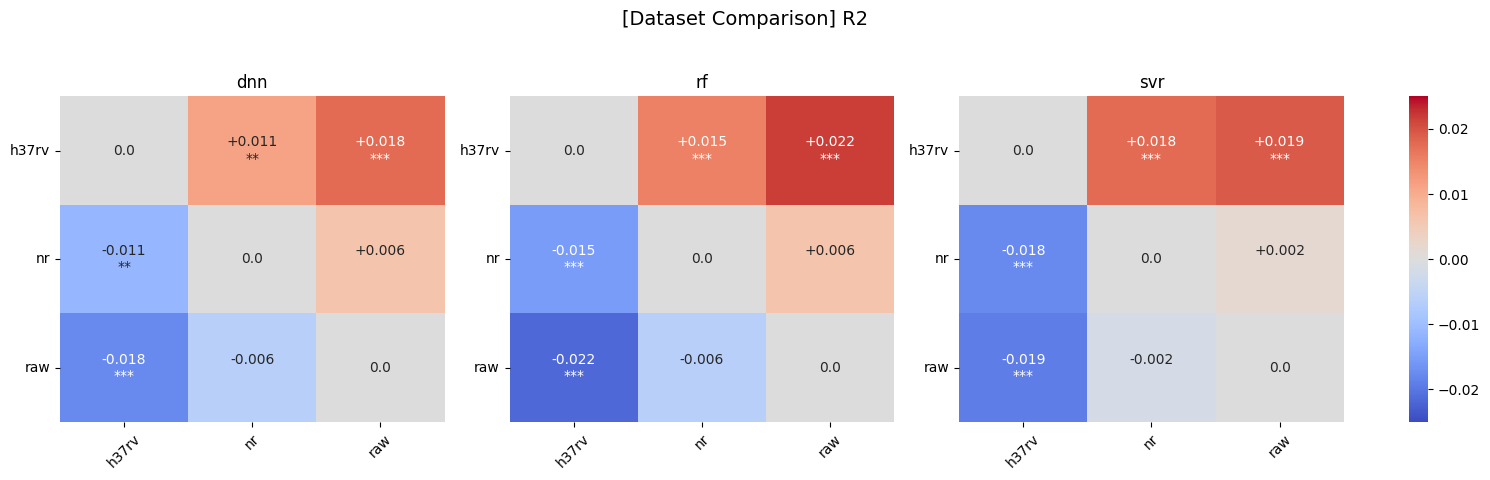

In [74]:
compare_datasets_within_each_model(df_all)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score

def compute_binary_metrics(y_true, y_pred, threshold=-2):
    y_true_bin = (y_true < threshold).astype(int)
    y_pred_bin = (y_pred < threshold).astype(int)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    return precision, recall

def annotate_metrics(ax, y_true, y_pred, threshold=-2, model=None, dataset=None, df_all=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rho, _ = spearmanr(y_true, y_pred)
    prec, rec = compute_binary_metrics(y_true, y_pred, threshold)

    metrics_text = (
        f"MAE = {mae:.2f}\n"
        f"MSE = {mse:.2f}\n"
        f"R² = {r2:.2f}\n"
        f"ρ = {rho:.2f}\n"
        f"Precision = {prec:.2f}\n"
        f"Recall = {rec:.2f}"
    )

    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.2))

def plot_3x3_regression_grid(df_all, threshold=-2):
    combos = sorted(df_all.groupby(["model", "dataset"]).groups.keys())
    n_rows, n_cols = 3, 3
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

    for idx, (model, dataset) in enumerate(combos):
        row, col = divmod(idx, n_cols)
        ax = axs[row, col]

        subset = df_all[(df_all["model"] == model) & (df_all["dataset"] == dataset)]

        ax.scatter(subset["Pred"], subset["Label"], alpha=0.5, s=10)

        lims = [
            min(subset["Pred"].min(), subset["Label"].min()),
            max(subset["Pred"].max(), subset["Label"].max())
        ]
        ax.plot(lims, lims, 'k--', lw=1)
        ax.axvline(threshold, color='red', ls=':', lw=0.8)
        ax.axhline(threshold, color='red', ls=':', lw=0.8)

        ax.set_title(f"{model.upper()} on {dataset}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Measured")

        annotate_metrics(
            ax,
            y_true=subset["Label"],
            y_pred=subset["Pred"],
            threshold=threshold,
            model=model,
            dataset=dataset,
            df_all=df_all
        )

    plt.tight_layout()
    plt.show()


In [24]:
def load_all_predictions_with_smiles(root_dir):
    all_files = find_all_prediction_files(root_dir)
    records = []

    for fpath in all_files:
        df = pd.read_csv(fpath)

        required = {'rep', 'fold', 'label', 'pred', 'smiles'}
        if not required.issubset(df.columns):
            print(f"[⚠️] Skipping: {fpath} (missing required columns)")
            continue

        model, dataset = parse_model_dataset_from_path(fpath)
        df["model"] = model
        df["dataset"] = dataset
        df["combo"] = f"{model}_{dataset}"
        df["Rep"] = df["rep"]
        df["Fold"] = df["fold"]

        records.append(df[["model", "dataset", "combo", "Rep", "Fold", "smiles", "label", "pred"]])

    return pd.concat(records, ignore_index=True).rename(columns={"label": "Label", "pred": "Pred"})


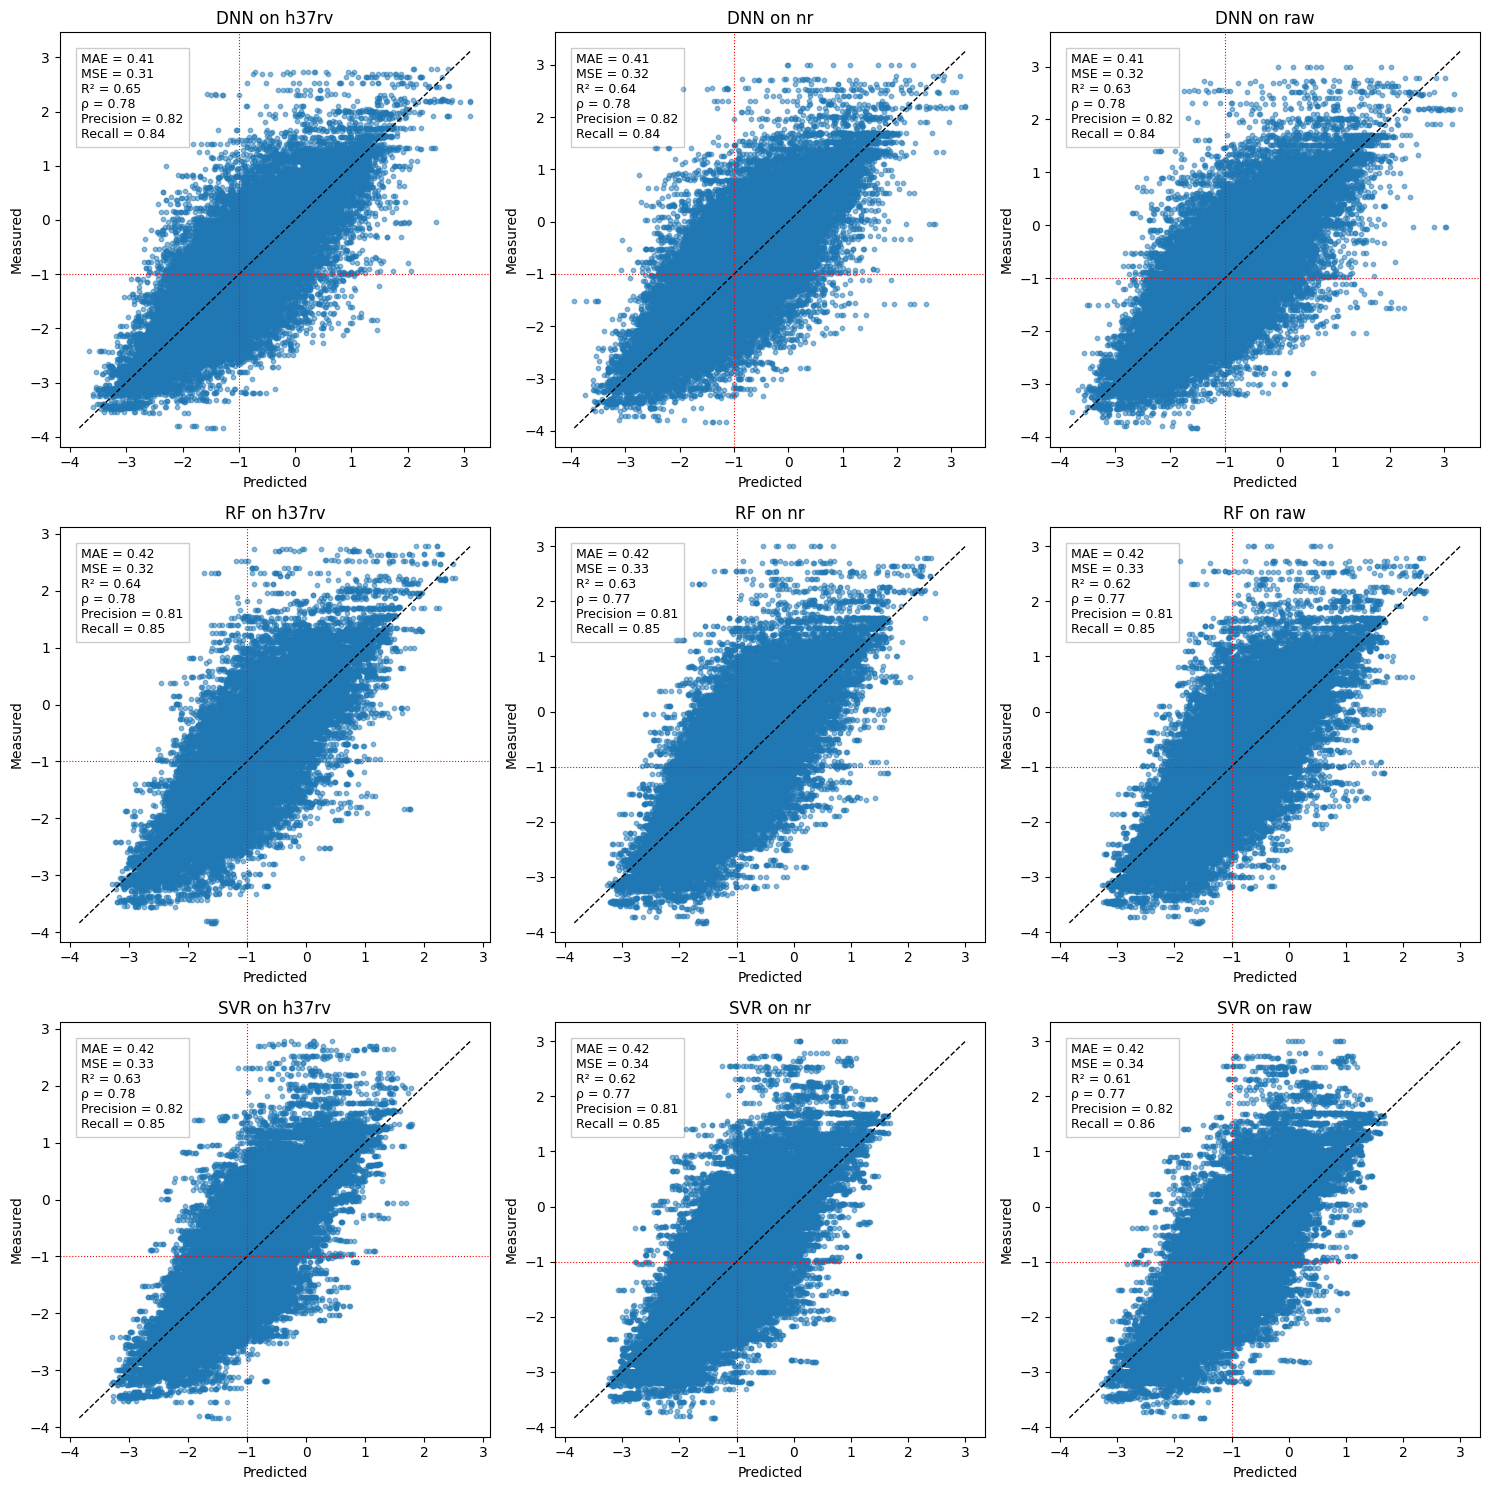

In [28]:
df_all_original = load_all_predictions_with_smiles(root_dir)
plot_3x3_regression_grid(df_all_original, threshold=-np.log10(10))